In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
# Ensure TensorFlow runs on GPU (optional)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU is available and configured.")

GPU is available and configured.


In [3]:
# Define dataset directories
ct_dataset_path = "C:/Users/karti/Desktop/Projects/DiagnoSphere/Dataset/BrainTumor/Brain Tumor CT scan Images"
mri_dataset_path = "C:/Users/karti/Desktop/Projects/DiagnoSphere/Dataset/BrainTumor/Brain Tumor MRI images"
img_size = (224, 224)
batch_size = 32

In [4]:
# Load datasets
ct_ds = image_dataset_from_directory(
    ct_dataset_path, batch_size=batch_size, image_size=img_size, shuffle=True
)
mri_ds = image_dataset_from_directory(
    mri_dataset_path, batch_size=batch_size, image_size=img_size, shuffle=True
)

Found 4618 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [5]:
# Combine datasets
dataset = ct_ds.concatenate(mri_ds)

In [6]:
# Split into train and validation sets (80-20 split)
train_size = int(0.8 * len(dataset))
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

In [7]:
# Apply prefetching for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [8]:
# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze base model

In [9]:
# Add custom classification layers
x = base_model.output  # Get base model output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
x = Dense(1, activation="sigmoid")(x)  # Binary classification

In [10]:
# Create model
model = Model(inputs=base_model.input, outputs=x)

In [11]:
# Compile model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [13]:
# Define checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint(
    "best_model.h5",  # File name to save
    monitor="val_accuracy",  # Monitor validation accuracy
    save_best_only=True,  # Save only the best model
    mode="max",  # Save when val_accuracy is maximized
    verbose=1
)

In [14]:
epochs=10
with tf.device('/GPU:0'):
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[checkpoint_callback])


Epoch 1/10
241/241 [==============================] - ETA: 0s - loss: 0.3154 - accuracy: 0.8579
Epoch 1: val_accuracy improved from -inf to 0.89627, saving model to best_model.h5
241/241 [==============================] - 45s 135ms/step - loss: 0.3154 - accuracy: 0.8579 - val_loss: 0.2434 - val_accuracy: 0.8963
Epoch 2/10
241/241 [==============================] - ETA: 0s - loss: 0.2175 - accuracy: 0.9103
Epoch 2: val_accuracy improved from 0.89627 to 0.92064, saving model to best_model.h5
241/241 [==============================] - 41s 168ms/step - loss: 0.2175 - accuracy: 0.9103 - val_loss: 0.1976 - val_accuracy: 0.9206
Epoch 3/10
241/241 [==============================] - ETA: 0s - loss: 0.1641 - accuracy: 0.9359
Epoch 3: val_accuracy improved from 0.92064 to 0.93880, saving model to best_model.h5
241/241 [==============================] - 28s 116ms/step - loss: 0.1641 - accuracy: 0.9359 - val_loss: 0.1538 - val_accuracy: 0.9388
Epoch 4/10
241/241 [==============================] - E

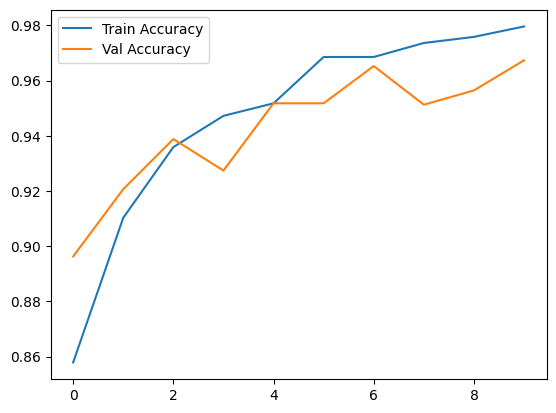

In [15]:
# Plot training history
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.show()